In [1]:
import reverse_geocoder as rg
import pycountry
import numpy as np
import pandas as pd
import warnings

In [2]:
combined_df = pd.read_csv('transformed_data/intergrated_data.csv')

### Add District, State, and Country Using Reverse Geocoding

**Purpose:**  
Enrich the dataset with geographic hierarchy information by extracting district, state, and country from latitude and longitude coordinates.

**Actions Performed:**  
1. Prepare a list of coordinates (`latitude`, `longitude`) for each listing.  
2. Perform reverse geocoding using the `reverse_geocoder` library to retrieve location information.  
3. Extract:
   - `district` (`admin2`) → the district or county of the listing  
   - `state` (`admin1`) → the state, province, or region  
   - `country_code` → the ISO 2-letter country code  
4. Map the ISO country code to the full **country name** using the `pycountry` library.

**Output:**  
- `district` column: Subdivision smaller than city  
- `state` column: State or region  
- `country_code` column: ISO code of the country  
- `country_name` column: Full country name  


In [3]:

# 1. Prepare coordinates as list of tuples (lat, lon)
coordinates = list(zip(combined_df['latitude'], combined_df['longitude']))

# 2. Perform reverse geocoding
results = rg.search(coordinates)

# 3. Extract district (admin2), state (admin1), and country code
combined_df['district'] = [x['admin2'] for x in results]       # District 
combined_df['state'] = [x['admin1'] for x in results]          # State 
combined_df['country_code'] = [x['cc'] for x in results]       # Country code

# 4. Map country code to full country name
combined_df['country_name'] = combined_df['country_code'].apply(
    lambda code: pycountry.countries.get(alpha_2=code).name
)

Loading formatted geocoded file...


In [4]:
combined_df

,id,price_total,room_type,is_shared_room,is_private_room,max_guests,is_superhost,is_multi_listing,is_business_listing,cleanliness_score,...,restaurant_index,restaurant_index_norm,longitude,latitude,city,day_type,district,state,country_code,country_name
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,...,98.253896,6.846473,4.90569,52.41772,amsterdam,weekday,Gemeente Landsmeer,North Holland,NL,Netherlands
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,...,837.280757,58.342928,4.90005,52.37432,amsterdam,weekday,Gemeente Amsterdam,North Holland,NL,Netherlands
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,...,95.386955,6.646700,4.97512,52.36103,amsterdam,weekday,Gemeente Diemen,North Holland,NL,Netherlands
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,...,875.033098,60.973565,4.89417,52.37663,amsterdam,weekday,Gemeente Amsterdam,North Holland,NL,Netherlands
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,...,815.305740,56.811677,4.90051,52.37508,amsterdam,weekday,Gemeente Amsterdam,North Holland,NL,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,1794,715.938574,Entire home/apt,False,False,6.0,False,0,1,10.0,...,438.756874,10.604584,16.37940,48.21136,vienna,weekend,Wien Stadt,Vienna,AT,Austria
51703,1795,304.793960,Entire home/apt,False,False,2.0,False,0,0,8.0,...,342.182813,8.270427,16.38070,48.20296,vienna,weekend,Wien Stadt,Vienna,AT,Austria
51704,1796,637.168969,Entire home/apt,False,False,2.0,False,0,0,10.0,...,282.296424,6.822996,16.38568,48.20460,vienna,weekend,Wien Stadt,Vienna,AT,Austria
51705,1797,301.054157,Private room,False,True,2.0,False,0,0,10.0,...,158.563398,3.832416,16.34100,48.19200,vienna,weekend,Wien Stadt,Vienna,AT,Austria


### Merge Airbnb Data with Crime Data by City

**Purpose:**  
Enrich the Airbnb dataset with crime rate information for each city.

**Steps Performed:**  
1. **Read crime data** from the CSV file and remove unnecessary columns (`Unnamed: 0`).  
2. **Standardize city names** to lowercase in both datasets to ensure consistent merging.  
3. **Merge the datasets** on the `city` column using an inner join (`how='inner'`), keeping only rows that exist in both datasets.  
4. **Handle duplicates:**  
   - If the crime data has multiple rows per city, duplicates are removed or aggregated to ensure a **one-to-one merge**.  

**Output:**  
- `merged_df` contains all Airbnb listings along with the corresponding **crime rate information** for each city.  
- The row count remains consistent and does not inflate due to duplicate city entries.  


In [5]:
crime_data = pd.read_csv('External_data/Crime_rate.csv')
crime_data.drop(r'Unnamed: 0', axis=1, inplace=True)
crime_data['city'] = crime_data['city'].str.lower()
merged_df = pd.merge(combined_df, crime_data, on='city', how='inner')

In [6]:
cost_df = pd.read_csv('External_data/Cost_of_living_index.csv')
cost_df['s'] = cost_df['City'].str.split(',')


In [7]:
for i in range(len(cost_df)):
    if isinstance(cost_df.at[i, 's'], list) and len(cost_df.at[i, 's']) > 0:
        cost_df.at[i, 'city'] = cost_df.at[i, 's'][0]
    else:
        cost_df.at[i, 'city'] = None

In [8]:
cost_df.drop(
    ['s','City'],
    axis=1,
    inplace=True
)

In [9]:
merged_df['city'] = merged_df['city'].str.capitalize()

In [10]:
merged_df.to_csv('transformed_data\merged_data_1.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_10464\4252065464.py:1: SyntaxWarning: invalid escape sequence '\m'
  merged_df.to_csv('transformed_data\merged_data_1.csv', index=False)


In [11]:
cost_df.to_csv('External_data\Cleaned_cost_of_living.csv')

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_10464\3429430362.py:1: SyntaxWarning: invalid escape sequence '\C'
  cost_df.to_csv('External_data\Cleaned_cost_of_living.csv')


In [12]:
cost_of_life_df = pd.read_csv("External_data/cost_of_living_per_city.csv")

In [13]:
cost_of_life_df

,city,Monthly_Average_Net_salary,Meal_at_Inexpensive_Restaurant,Taxi_price_per_Km,Monthly_Basic_Utilities,Monthly_Rent_One_Bedroom_CC,Monthly_Rent_One_Bedroom_OCC,Monthly_Rent_Three_Bedroom_CC,Monthly_Rent_Three_Bedroom_OCC
0,Amsterdam,4502.10,20.50,3.00,262.00,2178.68,1701.26,3725.50,2785.29
1,Athens,1164.49,15.00,0.95,184.56,614.42,519.21,1142.70,946.39
2,Barcelona,2102.82,15.00,1.86,159.12,1398.59,1061.18,2162.90,1684.62
3,Berlin,3136.14,15.00,2.80,347.11,1298.45,923.15,2431.82,1770.45
4,Budapest,1410.60,10.47,1.15,134.93,733.71,557.83,1412.20,1047.05
5,Lisbon,1304.65,13.75,0.90,137.93,1387.50,1036.00,2502.27,1633.33
6,London,4260.76,23.01,2.85,333.23,2788.44,2029.85,4402.56,3416.39
7,Paris,3305.14,15.00,1.50,238.30,1394.79,1039.17,3088.46,2145.00
8,Rome,1863.90,15.00,1.50,187.37,1280.45,820.59,2353.33,1541.67
9,Vienna,3135.20,18.25,1.90,291.20,1082.80,763.71,2063.57,1302.78


In [14]:
final_merge_df = pd.merge(merged_df,cost_of_life_df, how="left", on="city")

In [15]:
final_merge_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              51707 non-null  int64  
 1   price_total                     51707 non-null  float64
 2   room_type                       51707 non-null  str    
 3   is_shared_room                  51707 non-null  bool   
 4   is_private_room                 51707 non-null  bool   
 5   max_guests                      51707 non-null  float64
 6   is_superhost                    51707 non-null  bool   
 7   is_multi_listing                51707 non-null  int64  
 8   is_business_listing             51707 non-null  int64  
 9   cleanliness_score               51707 non-null  float64
 10  guest_satisfaction_score        51707 non-null  float64
 11  num_bedrooms                    51707 non-null  int64  
 12  distance_city_center            51707 non-n

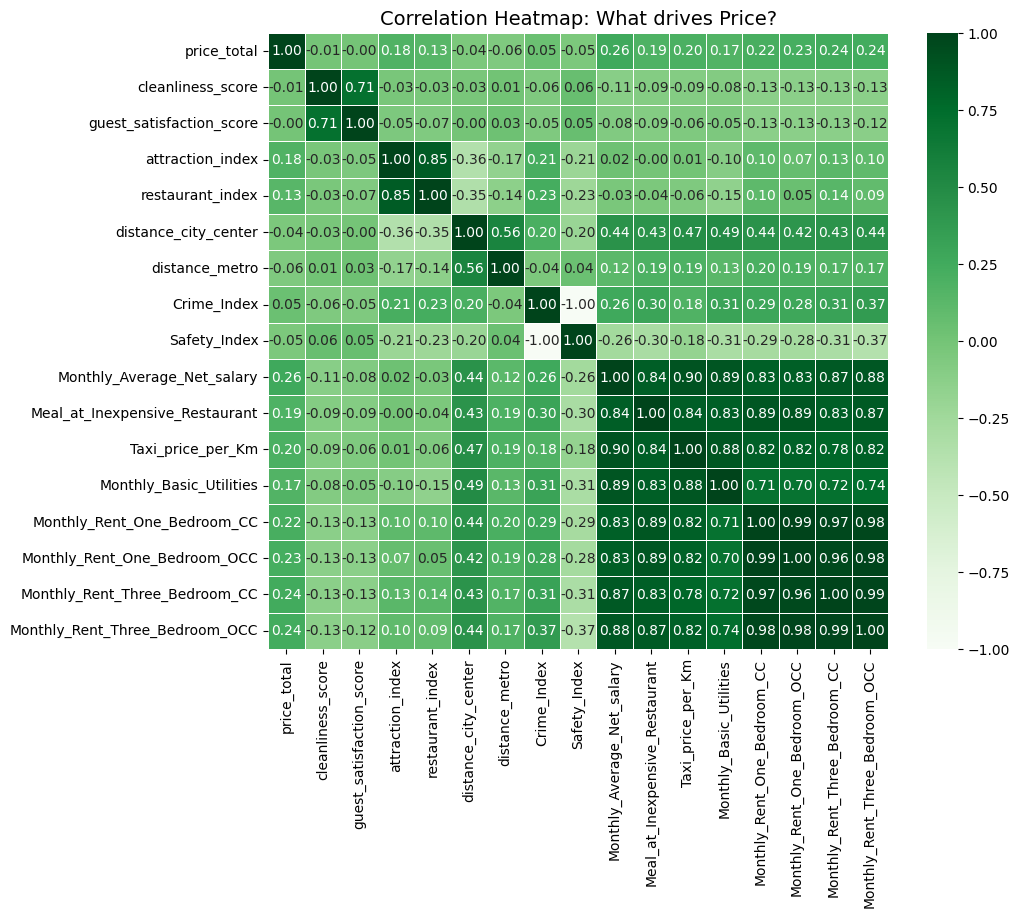

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols=[
  'price_total','cleanliness_score', 'guest_satisfaction_score', 
    'attraction_index', 'restaurant_index', 
    'distance_city_center', 'distance_metro', 
    'Crime_Index', 'Safety_Index',"Monthly_Average_Net_salary",
    "Meal_at_Inexpensive_Restaurant",
    "Taxi_price_per_Km",
    "Monthly_Basic_Utilities",
    "Monthly_Rent_One_Bedroom_CC",
    "Monthly_Rent_One_Bedroom_OCC",
    "Monthly_Rent_Three_Bedroom_CC",
    "Monthly_Rent_Three_Bedroom_OCC"
]


plt.figure(figsize=(10, 8))
sns.heatmap(final_merge_df[numeric_cols].corr(), annot=True, cmap='Greens', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: What drives Price?', fontsize=14)
plt.show()

In [17]:
final_merge_df.columns

Index(['id', 'price_total', 'room_type', 'is_shared_room', 'is_private_room',
       'max_guests', 'is_superhost', 'is_multi_listing', 'is_business_listing',
       'cleanliness_score', 'guest_satisfaction_score', 'num_bedrooms',
       'distance_city_center', 'distance_metro', 'attraction_index',
       'attraction_index_norm', 'restaurant_index', 'restaurant_index_norm',
       'longitude', 'latitude', 'city', 'day_type', 'district', 'state',
       'country_code', 'country_name', 'Crime_Index', 'Safety_Index',
       'Monthly_Average_Net_salary', 'Meal_at_Inexpensive_Restaurant',
       'Taxi_price_per_Km', 'Monthly_Basic_Utilities',
       'Monthly_Rent_One_Bedroom_CC', 'Monthly_Rent_One_Bedroom_OCC',
       'Monthly_Rent_Three_Bedroom_CC', 'Monthly_Rent_Three_Bedroom_OCC'],
      dtype='str')

In [18]:
final_merge_df["district"] = (
    final_merge_df["district"]
    .replace(["null", "NaN", "nan", ""], np.nan)
)
final_merge_df["state"] = (
    final_merge_df["state"]
    .replace(["null", "NaN", "nan", ""], np.nan)
)


In [19]:
final_merge_df["district"] = final_merge_df["district"].fillna(final_merge_df["city"])
final_merge_df["state"] = final_merge_df["state"].fillna(final_merge_df["city"])


In [20]:
final_merge_df.isna().sum().sort_values(ascending=False)

id                                0
price_total                       0
room_type                         0
is_shared_room                    0
is_private_room                   0
max_guests                        0
is_superhost                      0
is_multi_listing                  0
is_business_listing               0
cleanliness_score                 0
guest_satisfaction_score          0
num_bedrooms                      0
distance_city_center              0
distance_metro                    0
attraction_index                  0
attraction_index_norm             0
restaurant_index                  0
restaurant_index_norm             0
longitude                         0
latitude                          0
city                              0
day_type                          0
district                          0
state                             0
country_code                      0
country_name                      0
Crime_Index                       0
Safety_Index                

In [21]:
final_merge_df.drop("id", axis=1,inplace=True)

In [22]:
final_merge_df

,price_total,room_type,is_shared_room,is_private_room,max_guests,is_superhost,is_multi_listing,is_business_listing,cleanliness_score,guest_satisfaction_score,...,Crime_Index,Safety_Index,Monthly_Average_Net_salary,Meal_at_Inexpensive_Restaurant,Taxi_price_per_Km,Monthly_Basic_Utilities,Monthly_Rent_One_Bedroom_CC,Monthly_Rent_One_Bedroom_OCC,Monthly_Rent_Three_Bedroom_CC,Monthly_Rent_Three_Bedroom_OCC
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,715.938574,Entire home/apt,False,False,6.0,False,0,1,10.0,100.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78
51703,304.793960,Entire home/apt,False,False,2.0,False,0,0,8.0,86.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78
51704,637.168969,Entire home/apt,False,False,2.0,False,0,0,10.0,93.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78
51705,301.054157,Private room,False,True,2.0,False,0,0,10.0,87.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78


In [23]:
final_merge_df.state.isnull().sum()

np.int64(0)

In [25]:
final_merge_df.columns

Index(['price_total', 'room_type', 'is_shared_room', 'is_private_room',
       'max_guests', 'is_superhost', 'is_multi_listing', 'is_business_listing',
       'cleanliness_score', 'guest_satisfaction_score', 'num_bedrooms',
       'distance_city_center', 'distance_metro', 'attraction_index',
       'attraction_index_norm', 'restaurant_index', 'restaurant_index_norm',
       'longitude', 'latitude', 'city', 'day_type', 'district', 'state',
       'country_code', 'country_name', 'Crime_Index', 'Safety_Index',
       'Monthly_Average_Net_salary', 'Meal_at_Inexpensive_Restaurant',
       'Taxi_price_per_Km', 'Monthly_Basic_Utilities',
       'Monthly_Rent_One_Bedroom_CC', 'Monthly_Rent_One_Bedroom_OCC',
       'Monthly_Rent_Three_Bedroom_CC', 'Monthly_Rent_Three_Bedroom_OCC'],
      dtype='str')

In [26]:
#make boolen (true / false ) value to int (0/1)
final_merge_df['is_shared_room'] = final_merge_df['is_shared_room'].astype(int)
final_merge_df['is_private_room'] = final_merge_df['is_private_room'].astype(int)
final_merge_df['is_superhost'] = final_merge_df['is_superhost'].astype(int)
final_merge_df['is_multi_listing'] = final_merge_df['is_multi_listing'].astype(int)
final_merge_df['is_business_listing'] = final_merge_df['is_business_listing'].astype(int)
final_merge_df.info()



<class 'pandas.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_total                     51707 non-null  float64
 1   room_type                       51707 non-null  str    
 2   is_shared_room                  51707 non-null  int64  
 3   is_private_room                 51707 non-null  int64  
 4   max_guests                      51707 non-null  float64
 5   is_superhost                    51707 non-null  int64  
 6   is_multi_listing                51707 non-null  int64  
 7   is_business_listing             51707 non-null  int64  
 8   cleanliness_score               51707 non-null  float64
 9   guest_satisfaction_score        51707 non-null  float64
 10  num_bedrooms                    51707 non-null  int64  
 11  distance_city_center            51707 non-null  float64
 12  distance_metro                  51707 non-n

In [27]:
final_merge_df.to_csv("transformed_data/final_data.csv", index = False)